<a href="https://colab.research.google.com/github/arkothiwala/QuoraQuestionPairs/blob/master/Kaggle_tensorflow_speech_recognition_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting Started...

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json #Need to upload kaggle.json file from C:\Users\<USERNAME>\.kaggle\

In [2]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 75.9MB/s]
100% 1.04G/1.04G [00:18<00:00, 95.1MB/s]
100% 1.04G/1.04G [00:18<00:00, 62.0MB/s]
100% 2.45G/2.46G [00:37<00:00, 73.8MB/s]
100% 2.46G/2.46G [00:37<00:00, 70.3MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 46.3kB/s]


In [3]:
!7z x train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav                                                         0% 43 - train/audio/_background_noise_/white_noise.wav

In [0]:
rm -r test

In [0]:
!7z x -bd test.7z

### Reading Audio files

In [114]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
!pip install pydub
from pydub import AudioSegment

In [115]:
root = './train/audio/'
raw_audio = []
category = []
unknown = []
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unk_classes = []
background = []
from tqdm import tqdm
for cat in tqdm(os.listdir(root)):
  if(cat == '_background_noise_'):
    for fid in os.listdir("{}{}".format(root, cat)):
      if(fid.endswith("wav")):
        #audio = AudioSegment.from_wav("{}{}/{}".format(root, cat, fid))
        samplerate, audio = wavfile.read("{}{}/{}".format(root, cat, fid))
        background.append(audio)
  else:
    for fid in os.listdir("{}{}".format(root, cat)):
      if(fid.endswith("wav")):
        #audio = AudioSegment.from_wav("{}{}/{}".format(root, cat, fid))
        samplerate, audio = wavfile.read("{}{}/{}".format(root, cat, fid))
        if(cat in classes):
          raw_audio.append(audio)
          category.append(cat)
        else:
          unknown.append(audio)
          if(cat not in unk_classes):
            unk_classes.append(cat)

 26%|██▌       | 8/31 [00:00<00:02,  7.80it/s]/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
100%|██████████| 31/31 [00:03<00:00,  8.91it/s]


### Padding Sequence

In [0]:
#Check length of raw input files
def get_signallen_distribution(np_audio):
  """
  Expects a list/array of audio files represented by np.ndarray(xxx,)
  """
  d = {}
  for i in range(len(np_audio)):
    l = len(np_audio[i])
    if l not in d:
      d[l] = 1
    else:
      d[l] += 1
  return d

In [117]:
print("categorical audio min_len = {} and max_len = {} \nunknown audio has min_len = {} and max_len = {}".format(
          min(get_signallen_distribution(raw_audio).keys()),
          max(get_signallen_distribution(raw_audio).keys()),
          min(get_signallen_distribution(unknown).keys()),
          max(get_signallen_distribution(unknown).keys())))

categorical audio min_len = 6688 and max_len = 16000 
unknown audio has min_len = 5945 and max_len = 16000


So the data has maximum lenth of 16000... Hence, we will need to pad the data before computing spectogram

In [0]:
from keras.preprocessing.sequence import pad_sequences
raw_audio = pad_sequences(raw_audio, maxlen=16000)
unknown = pad_sequences(unknown, maxlen=16000)

### Superpositioning signal data with background audio

In [0]:
def mergeAudio(audios, backgrounds):
  for i in range(len(audios)):
    audio_len = len(audios[i])
    bg_id = np.random.randint(len(backgrounds))
    bg_len = len(backgrounds[bg_id])
    start_index = np.random.randint(bg_len - audio_len)
    end_index = start_index + audio_len
    audios[i] = audios[i] + backgrounds[bg_id][start_index:end_index]
  return audios

In [0]:
from copy import deepcopy
raw_audio_copy = deepcopy(raw_audio)

In [0]:
raw_audio = mergeAudio(raw_audio, background)
unknown = mergeAudio(unknown, background)

### Calc Spectrograms

In [0]:
nfft = 200 # Length of each window segment
fs = 16000 # Sampling frequencies
noverlap = 120 # Overlap between windows

In [0]:
from scipy.signal import spectrogram

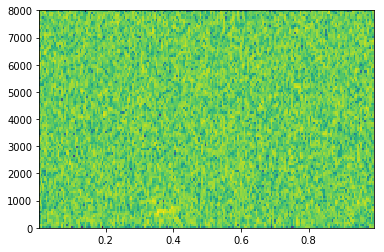

In [253]:
pxx, freqs, bins, im = plt.specgram(raw_audio[0], nfft, fs, noverlap = noverlap)

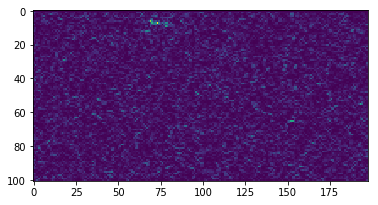

In [261]:
plt.imshow(pxx_scipy)

In [0]:
pxx_scipy = spectrogram(raw_audio[0], fs = fs, nfft = nfft, noverlap=noverlap, nperseg=nfft)[2]

In [0]:
def prepareSpecgram(audio):
  op = []
  for index in tqdm(range(len(audio))):
    pxx, freqs, bins, im = plt.specgram(audio[index], nfft, fs, noverlap = noverlap)
    op.append(pxx)
  return op

In [245]:
import gc
del pxx, freqs, bins, im
gc.collect()

112

 17%|█▋        | 4026/23682 [05:20<1:17:08,  4.25it/s]

KeyboardInterrupt: ignored

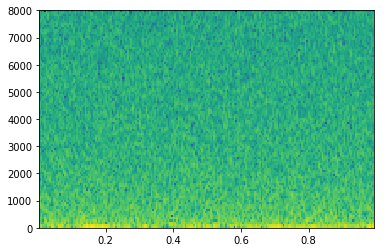

In [243]:
x = prepareSpecgram(raw_audio)

(101, 198)


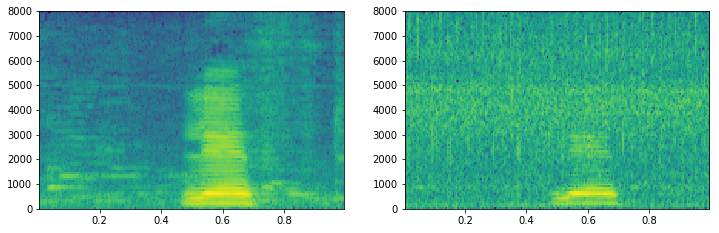

In [237]:
index = 15
plt.figure(figsize=(12,8))
plt.subplot(221)
pxx_raw, freqs_raw, bins_raw, im_raw = plt.specgram(raw_audio_copy[index], nfft, fs, noverlap = noverlap)
plt.subplot(222)
pxx, freqs, bins, im = plt.specgram(raw_audio[index], nfft, fs, noverlap = noverlap)
print(pxx.shape)

In [238]:
print(raw_audio_copy[index].mean(), raw_audio[index].mean(), np.median(raw_audio_copy[index]), np.median(raw_audio[index]))
print(pxx_raw.mean(), pxx.mean(), np.median(pxx_raw), np.median(pxx))
print("category =",category[index])

-3.6558125 8.1108125 -2.0 -31.0
1186.3805135006253 1855.8234121255869 0.09405771299207902 369.5067976848103
category = left


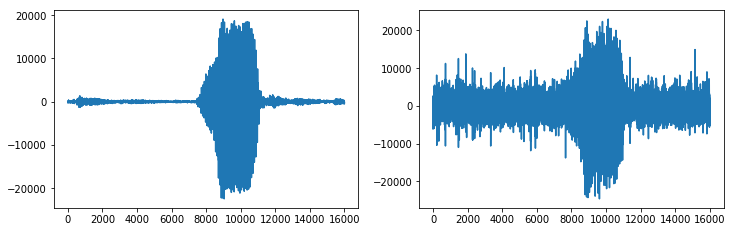

In [239]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(raw_audio_copy[index])
plt.subplot(222)
plt.plot(raw_audio[index])

### Test Data

In [0]:
test_raw = []
for fid in os.listdir("./test/audio/")[:50]:
    audio = AudioSegment.from_wav("./test/audio/"+fid)
    test_raw.append(audio)
  #AudioSegment.from_wav("./test/audio")

In [21]:
print(len(raw_audio), len(unknown), len(background))

23682 41039 6


In [0]:
n = len(background)
for i in raw_audio[:10]:
  bg_id = np.random.randint(n)

In [41]:
raw_audio[0].get_array_of_samples()

array('h', [44, 160, 67, 143, 268, 227, 196, 252, 323, 202, 219, 288, 146, 124, 108, 117, 140, 122, 189, 162, 239, 204, 188, 303, 168, 84, 85, 53, 63, 44, 80, 141, 120, 103, 5, -85, -55, -79, -35, -52, -89, 29, -12, 29, 37, 101, 212, 113, 26, -105, -46, -65, -145, -54, -96, -72, -43, -119, -29, -90, -119, 4, -99, 17, 40, 20, 201, 171, 87, -38, -43, -111, -100, -25, -146, -62, 20, -7, 0, 49, -4, -34, -50, -20, 31, -62, 18, 21, -17, 97, 5, -114, -113, -204, -254, -182, -76, -115, -174, -76, -29, 13, -54, -85, -40, -167, -112, -157, -166, -137, -183, -123, -205, -126, -192, -225, -197, -217, -150, -265, -154, -64, -113, 14, -96, -181, -152, -281, -231, -186, -64, -65, -195, -154, -162, -216, -218, -43, -73, -126, -142, -213, -127, -165, -114, -5, -49, -75, -117, -127, -97, -106, -31, -14, -181, -226, -167, -131, -56, 1, -17, -24, 38, -51, -54, -2, -105, -101, -66, -68, -43, -83, -166, -137, -55, 55, 57, 3, -38, 50, 129, 11, 19, -75, -80, 40, 97, 88, 17, 1, -105, -55, 19, 80, 127, 139, 35,

In [27]:
background[0].overlay(raw_audio[11])

In [0]:
import pandas as pd
try:
  submission = pd.read_csv('./sample_submission.csv')
except:
  !7z x sample_submission.7z
  submission = pd.read_csv('./sample_submission.csv')

In [39]:
submission.label.value_counts()

silence    158538
Name: label, dtype: int64